## Large Policy v2: Model-based approach

Given unknown `(s, a, r, sp)` data, find optimal policy. Not all `(s, a)` pairs will be seen in data, so interpolate from neighbors.
- States: |S| = 302020
- Actions: 9 actions
- Discount factor = 0.95

Lisa Fung

Last Updated: 11/9/24

### Data Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
large_data = pd.read_csv("./data/large.csv")
n_states = 302020
n_actions = 9
# n_limit_actions = 5

Large Data Observations

Rewards
- Only 7 unique values: [-10  -5   0   5  10  50 100]
- r=100 only at states sp = 301013, 301111, via actions [1,4]
- sp = 301013
    - s=301012, a=1 (delta_s = +1)
    - s=301014, a=2 (delta_s = -1)
    - s=301113, a=3 (delta_s = -100)
    - s=300413, a=4 (delta_s = +600)
- sp = 301111
    - s=301110, a=1 (delta_s = +1)
    - s=301112, a=2 (delta_s = -1)
    - s=301211, a=3 (delta_s = -100)
    - s=301011, a=4 (delta_s = +100)


Actions
- a = [1,4] are probabilistic
- a = [5,9] are usually 0, occasionally random
    ```

### Approach

- Transition Model: $T(s' - s \mid a)$
- Rewards: $R(s, s')$
- Only take actions $a = 1,2,3,4,5$


#### Transition Model

$T(a, \Delta s) = T(\Delta s \mid a)$
- $|\Delta s| = 9$, $|A| = 5$

In [3]:
large_data['delta_s'] = large_data['sp'] - large_data['s']  # delta_s = sp - s

# Only keep delta_s for actions [1, 4] and 0
# array([-600, -100,   -6,   -1,    0,    1,    6,  100,  600])
delta_s_list = np.sort(large_data[large_data['a'] == 1]['delta_s'].unique())

In [4]:
n_delta_s = 9
n_limit_actions = 5

T = np.zeros((n_limit_actions+1, n_delta_s))
T.shape

(6, 9)

In [5]:
large_data_a_delta_s = large_data[large_data['delta_s'].isin(delta_s_list)][['a', 'delta_s']].value_counts().sort_index(level=[0,1])

In [6]:
# Aggregate transition counts
for (a, delta_s), count in large_data_a_delta_s.items():
    # row: ((a, delta_s), count)
    if a <= n_limit_actions:
        delta_s_idx = np.where(delta_s_list == delta_s)[0][0]
        T[a, delta_s_idx] = count

In [7]:
# Normalize along next state (sp) dimension to divide by N(s, a)
T /= np.sum(T, axis=1, keepdims=True)
T = np.nan_to_num(T, nan=0.0)   # convert nan to 0.0

C:\Users\lisaf\AppData\Local\Temp\ipykernel_8884\2452209420.py:2: RuntimeWarning: invalid value encountered in divide
  T /= np.sum(T, axis=1, keepdims=True)


Reward Model
- $R(s, s')$ uniquely determines reward value
- Previously: large sparse array to hold rewards
- Update: Dictionary `((s, sp) : r)` to hold nonzero rewards

In [8]:
rewards_list = np.sort(large_data['r'].unique())
rewards_list

array([-10,  -5,   0,   5,  10,  50, 100])

In [9]:
# for r in rewards_list[0:1]:
#     print(f"Reward r = {r}:")
#     print(large_data[large_data['r'] == r][['s', 'sp', 'a', 'r']].value_counts().sort_index())
#     print(large_data[large_data['sp'] == 301112][['s', 'sp']].value_counts())

In [37]:
# Determine if any (s, sp) pair has different rewards
# Answer: no. Reward is uniquely determined by R(s, sp)
large_data.groupby(['s', 'sp'])['r'].nunique().unique()

array([1])

In [32]:
states_list = np.sort(large_data['s'].unique())
n_seen_states = len(states_list)    # 500

# R = np.zeros((n_seen_states, n_seen_states))
# Large sparse array for R:
# R = large_data.pivot_table(index='s', columns='sp', values='r', aggfunc='first').to_numpy()

In [ ]:
# large_data.pivot_table(index='sp', columns='s', values='r', aggfunc='first')[300413][301013]
# # large_data[(large_data['s'] == 300413) & (large_data['sp'] == 301013)]

# Check R indices
test_s = 301014
test_s_idx = np.where(states_list == test_s)[0][0]
test_sp = 301013
test_sp_idx = np.where(states_list == test_sp)[0][0]
# R[test_s_idx, test_sp_idx]

np.float64(100.0)

In [43]:
# Rewards as dictionary with (s, sp) : r
large_data_rewards = large_data[large_data['r'] != 0]
R_dict = large_data_rewards.set_index(['s', 'sp'])['r'].to_dict()
len(R_dict)

64

#### Actions

In [13]:
actions_list = np.arange(1, n_limit_actions+1)
actions_list

array([1, 2, 3, 4, 5])

#### Value Iteration
1. Find optimal policy $\pi^*$ using **Value Iteration**

    a. Find $U^*(s)$ by updating $U_{k+1}(s) = \max_a ( R(s,a) + \gamma * \sum_{s'} T(s' | s,a) \cdot U_k(s'))$ until convergence when maximum change in value $||U_{k+1} - U_{k}||_{\infty} < \delta$. Since $R(s, a) = R(s, s')$, we use 
    $$U_{k+1}(s) = \max_a Q(s, a) = \max_a ( \sum_{s'} T(s' | s,a) \cdot [R(s,s') + \gamma \cdot U_k(s')])$$

    b. Extract $\pi^*$ with $\pi^*(s) = \argmax_a ( R(s,a) + \gamma * \sum_{s'} T(s' | s,a) \cdot U^*(s') )$

In [ ]:
# Test code for value iteration logic
def test_value_iter_logic():
    for s_idx, s in enumerate([301113]):
        print("State s:", s)
        for a in actions_list[0:1]:
            for delta_s_idx, delta_s in enumerate(delta_s_list):
                sp = s + delta_s
                print("State sp:", sp)
                print("Delta_s:", delta_s_idx, delta_s)
                print("T(sp | s, a):", T[a, delta_s_idx])
                print("R(s, sp):", R_dict[(s, sp)] if (s, sp) in R_dict else None)
                
                print()
    # print([delta_s+states_list[0] in states_list for delta_s in delta_s_list])

In [56]:
def value_iteration(U, n_iters=100, discount=0.95, threshold=1e-3):
    # Update U with intermediate state updates instead of one iteration at a time
    residual = 0
    for i in range(n_iters):
        residual = 0    # Maximum change in value among all U[s]
        for s in range(1, len(U)):  # Iterate through all states
            max_Us = 0
            for a in actions_list:
                Q_sa = 0
                for delta_s_idx, delta_s in enumerate(delta_s_list):
                    sp = s + delta_s
                    # Ignoring edge cases where action goes out of bounds (0 reward)
                    if sp > 0 and sp < len(U):
                        r = R_dict[(s, sp)] if (s, sp) in R_dict else 0
                        Q_sa += T[a, delta_s_idx] * (r + discount * U[sp])
                max_Us = max(max_Us, Q_sa)
            residual = max(residual, abs(U[s] - max_Us))
            U[s] = max_Us
        if residual < threshold:
            print(f"Value iteration converged within threshold {threshold} at iteration {i}\n")
            break
    return U, residual

### Extract Policy from Value Function U

In [54]:
U = np.zeros(n_states+1)

In [57]:
U_updated, residual = value_iteration(U)

In [ ]:
np.save("large_U_value_iteration_100iters.npy", U_updated)
loaded_arr = np.load("large_U_value_iteration_100iters.npy")
# sum(U_updated == loaded_arr)

np.int64(302021)

In [59]:
# Extract optimal policy pi(s) = a from value function U(s)

def extract_policy(U, discount=0.95):
    policy = np.zeros(n_states+1)
    for s in range(1, n_states+1):
        max_action = 0
        max_action_value = -float('inf')
        for a in actions_list:
            Q_sa = 0
            for delta_s_idx, delta_s in enumerate(delta_s_list):
                sp = s + delta_s
                # Ignoring edge cases where action goes out of bounds (0 reward)
                if sp > 0 and sp < len(U):
                    r = R_dict[(s, sp)] if (s, sp) in R_dict else 0
                    Q_sa += T[a, delta_s_idx] * (r + discount * U[sp])
            if Q_sa > max_action_value:
                max_action = a
                max_action_value = Q_sa
        policy[s] = max_action

    return policy

In [60]:
optimal_policy = extract_policy(U)

In [61]:
np.unique(optimal_policy, return_counts=True)

(array([0., 1., 2., 3., 4.]), array([     1,  99385,   7153,  80213, 115269]))

In [62]:
# Write optimal policy to file
with open("large.policy", "w") as file:
    for a in optimal_policy[1:]:
        file.write(f"{int(a)}\n")

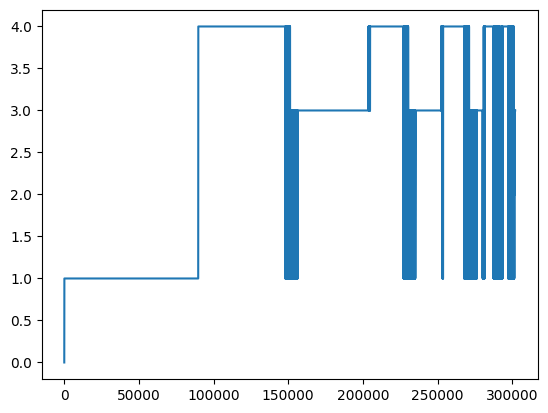

In [64]:
plt.plot(optimal_policy)

### Future Improvements

- Average values of Q(s, a) with some distance-dependent discount for unvisited states s